In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Display the columns and data in dictionary format ******** LOOK AT
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d3c34126a0>,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
# Display the columns and data in dictionary format ********* LOOK AT
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d3c3420b38>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [11]:
# Take a look at the first 5 records ********* LOOK AT
session.query(Measurement.date, Measurement.id, Measurement.tobs, Measurement.station, Measurement.prcp).limit(5).all() 

[('2010-01-01', 1, 65.0, 'USC00519397', 0.08),
 ('2010-01-02', 2, 63.0, 'USC00519397', 0.0),
 ('2010-01-03', 3, 74.0, 'USC00519397', 0.0),
 ('2010-01-04', 4, 76.0, 'USC00519397', 0.0),
 ('2010-01-06', 5, 73.0, 'USC00519397', None)]

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(f"The most recent date in the data set is {recent_date}.")

The most recent date in the data set is 2017-08-23.


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
one_year = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                filter((Measurement.date >= one_year) & (Measurement.date <= recent_date)).all()
                #filter(Measurement.date >= one_year).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'precipitation']).set_index('date')
prcp_df.dropna(how='any',inplace=True)  

# Sort the dataframe by date
prcp_df.sort_values(['date'], inplace=True, ascending=True)
prcp_df.head()                         

,precipitation
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


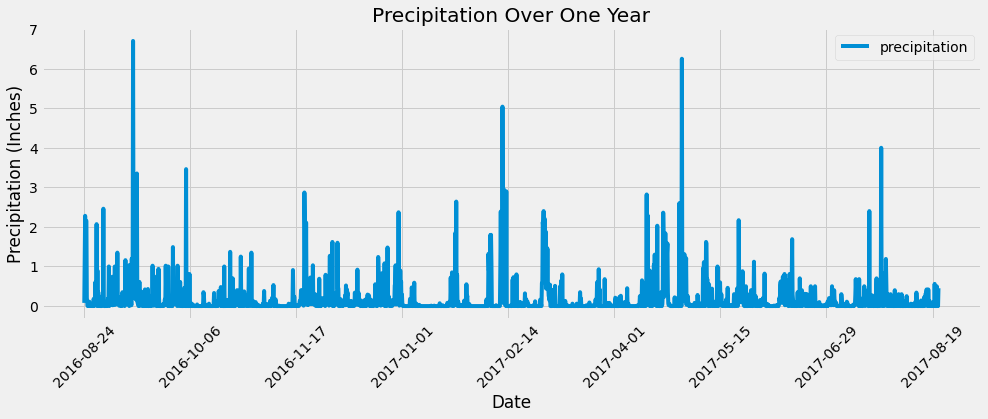

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=45, figsize=(15,5))
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.title("Precipitation Over One Year")
#plt.savefig("PrecipitationBar")
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station.id).count()
print(f"There are {num_stations} stations in this dataset.")

There are 9 stations in this dataset.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#lowest_temp = most_active[0].id == Measurement.tobs.min()
station_id = most_active[0][0]
min_max_avg = session.query(func.min(Measurement.tobs), 
                            func.max(Measurement.tobs),
                            func.avg(Measurement.tobs)).filter(Measurement.station == station_id).all()
all = list(np.ravel(min_max_avg))
print(f"For station id {station_id} the min temp is {all[0]}, the max temp is {all[1]}, the avg temp is {all[2]:1.2f}.")

For station id USC00519281 the min temp is 54.0, the max temp is 85.0, the avg temp is 71.66.


In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temp = session.query(Measurement.date, Measurement.tobs).\
                filter((Measurement.date >= one_year) & (Measurement.date <= recent_date)).\
                filter(Measurement.station == station_id).all()
one_year_temp

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

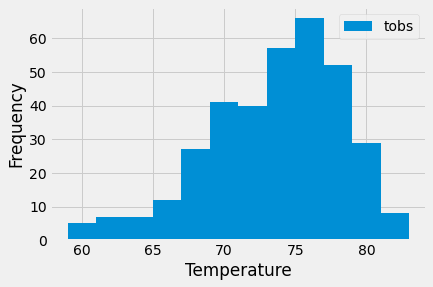

In [32]:
tobs_df = pd.DataFrame(one_year_temp, columns=['date','tobs'])
tobs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
#plt.savefig("TempHist")
plt.show()

# Close session

In [33]:
# Close Session
session.close()